In [1]:
import sys
import os 
import numpy as np
import seaborn.apionly as sns
import astropy.constants as ac
from matplotlib import ticker
import matplotlib.pyplot as plt
plt.style.use('papers')
%matplotlib inline
root_path = '/home/wtb2/Documents'
sys.path.append(os.path.join(root_path,'EBTEL_analysis/src/'))
import ebtel_run as ebr
import ebtel_configure as ebc
import ebtel_plot as ebp

/opt/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/opt/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


# Hot Plasma Paper 1–Figures, Appendix

Here, we'll build the figure(s) needed for Hot Plasma Paper 1 Appendix.

## Figure 1
The first figure will show the relative importance of $\psi_{TR}$ in the EBTEL two-fluid equations. Consider the equation,
$$
\frac{L}{\gamma - 1}\frac{dp_e}{dt} = \psi_{TR} - (\mathcal{R}_C + \mathcal{R}_{TR}) + \frac{L}{\gamma - 1}k_Bn\nu_{ei}(T_i - T_e) + LQ_e.
$$
We want to plot each term as a function of time to show their relative contributions to the evolution of the electron energy.

We will use the following parameters for our sample run:

+ $L=40$ Mm
+ $\tau=20$ s
+ $H_0=1.0$ erg cm$^{-3}$ s$^{-1}$
+ Spitzer conduction

Write function to calculate electron-ion heating frequency.

In [2]:
def calc_nu_ei(n,Te):
    c1 = 16.*np.sqrt(np.pi)/3.
    c2 = ac.e.gauss.value**4/(ac.m_e.cgs.value*ac.m_p.cgs.value)
    c3 = 2.*ac.k_B.cgs.value*Te/ac.m_e.cgs.value
    colLog = 20.
    return c1*c2*c3**(-3./2.)*n*colLog

Configure dictionary to run EBTEL-2fluid model.

In [3]:
#input dictionary
config_dict = {'usage_option':'dem','rad_option':'rk','dem_option':'new','heat_flux_option':'classical',
              'solver':'euler','ic_mode':'st_eq','print_plasma_params':'True','heat_species':'electron'}
config_dict['total_time'] = 5000
config_dict['tau'] = 1.0
config_dict['rka_error'] = 1.0e-6
config_dict['index_dem'] = 451
config_dict['sat_limit'] = 1.0/6.0
config_dict['h_back'] = 3.5e-5
config_dict['heating_shape'] = 'triangle'
config_dict['t_start_switch'] = 'uniform'
config_dict['t_end_switch'] = 'uniform'
config_dict['T0'] = 1.0e+6
config_dict['n0'] = 1.0e+8
config_dict['t_start'] = 0.0
config_dict['mean_t_start'] = 1000
config_dict['std_t_start'] = 1000
config_dict['amp_switch'] = 'uniform'
config_dict['amp0'] = 0.001
config_dict['amp1'] = 0.01
config_dict['alpha'] = 1.5
config_dict['loop_length'] = 40.0
config_dict['num_events'] = 1
config_dict['t_pulse_half'] = 10
config_dict['h_nano'] = 1.0
config_dict['sample_rate'] = 1
config_dict['output_file'] = '/home/wtb2/Documents/research_notebook/EBTEL/ebtel_data/psi_TR_testing'

In [4]:
configurer = ebc.Configurer(config_dict,'')

In [5]:
configurer.print_xml_config(config_file=config_dict['output_file']+'.xml')

Now, run the two-fluid EBTEL code with this configuration.

In [6]:
runner = ebr.Runner('/home/wtb2/Documents/EBTEL-2fluid_repo/bin/','')

In [7]:
runner.run_ebtel_single(config_dict['output_file']+'.xml')

Next, load the data and plot.

In [8]:
data = np.loadtxt(config_dict['output_file']+'.txt')
t = data[:,0]
Te = data[:,1]
Ti = data[:,2]
n = data[:,3]
fce = data[:,12]
fci = data[:,13]
q = data[:,15]
rad = data[:,-2]
r3 = data[:,-3]

Calculate the relevant quantities.

In [9]:
delta_terms = []
delta_terms.append(fce/(config_dict['loop_length']*1.e+8)/(1.+Te/Ti))
delta_terms.append(-fci/(config_dict['loop_length']*1.e+8)*(Te/Ti)/(1.+Te/Ti))
delta_terms.append(-(Te/Ti*(r3+1.) + 1.)/(1.+Te/Ti)*n**2*rad)
#delta_terms.append(q)
tmp = np.zeros(len(Te))
for i in range(len(Te)):
    tmp[i] = ac.k_B.cgs.value/(5./3. - 1.)*n[i]*calc_nu_ei(n[i],Te[i])*(Ti[i] - Te[i])
delta_terms.append(tmp)

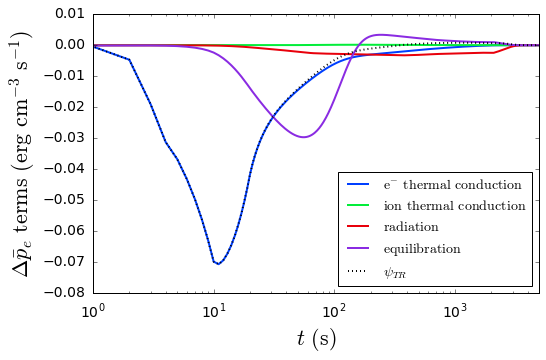

In [12]:
labels = [r'$\mathrm{e}^{-}$ $\mathrm{thermal}$ $\mathrm{conduction}$',
          r'$\mathrm{ion}$ $\mathrm{thermal}$ $\mathrm{conduction}$',
          r'$\mathrm{radiation}$',r'$\mathrm{equilibration}$']
fig = plt.figure(figsize=(8,5))
ax = fig.gca()
#axT = ax.twinx()
for i in range(len(delta_terms)):
        ax.plot(t,delta_terms[i],color=sns.color_palette('bright')[i],label=labels[i])
ax.plot(t,1.0/(config_dict['loop_length']*1.e+8)*1./(1.+Te/Ti)*(fce + (r3*(config_dict['loop_length']*1.e+8)*(n**2)*rad)-Te/Ti*fci),
       linestyle='dotted',color='k',label=r'$\psi_{TR}$')
#axT.plot(t,Te/1e+6,linestyle='dashed',color='k')
ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlim([1,config_dict['total_time']])
ax.set_xlabel(r'$t$ $\mathrm{(s)}$')
ax.set_ylabel(r'$\Delta\bar{p}_e$ $\mathrm{terms}$ $(\mathrm{erg}$ $\mathrm{cm}^{-3}$ $\mathrm{s}^{-1})$')
box = ax.get_position()
#ax.set_position([box.x0, box.y0, box.width * 0.95, box.height])
ax.legend(loc='best')
plt.savefig('/home/wtb2/Documents/papers/hot_non-flaring_plasma_1/figures/psi_TR_compare.pdf')
plt.show()